# Country Clusters

### Objective: To build a model which clusters countries

We fill fit some unsupervised clustering models to determine whether similar countries (in terms of their demography, economic state, etc.) also generate differring amounts of refugees. 

In [1]:
## Read in csvs
import pandas as pd

dataset = pd.read_csv('/Users/joel/Documents/Brainstation/Tablaeu/CLEANDATA/clean_merged_all.csv').drop('Unnamed: 0', axis=1)
refugees = pd.read_csv('/Users/joel/Documents/Brainstation/Tablaeu/immigrantbyorigin.csv')

In [2]:
### Getting titles for each heading:

fields = []

for i,j in enumerate(dataset.columns):
    if i>=1 and i<=40:
        fields.append(j)
        
titles = {}

for field in fields:
            path = '/Users/joel/Documents/Brainstation/Tablaeu/UNINFO/'+field+'.csv'
            file = pd.read_csv(path, encoding='ISO-8859-1')
            
            heading = field
            title = file.columns[-1]

            titles[heading] = title

In [3]:
### Adding the sum of all arrivals to dataset

sums = []

for index in dataset.index:
    sums.append(dataset.loc[index,'Alabama':].sum(0))
    
dataset['sum_destination'] = sums

In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler


X_train = dataset.loc[:,'Demography4':'Work8']

scale = StandardScaler()
X_train = scale.fit_transform(X_train)

y_train = dataset.loc[:,'sum_destination']


In [5]:
###Importing sklearn models and plt

from sklearn.cluster import DBSCAN, KMeans
from matplotlib import pyplot as plt

Text(0,0.5,'Inertia')

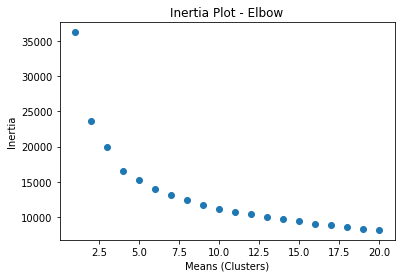

In [7]:
### Check how many means by looking and plotting elbow

score = []
ex = []
for tries in range(1,21):
    db = KMeans(tries)
    db.fit(X_train, y_train)
    inertia = db.inertia_
    score.append(inertia)
    clusters = tries
    ex.append(clusters)

plt.scatter(ex, score)
plt.title('Inertia Plot - Elbow')
plt.xlabel('Means (Clusters)')
plt.ylabel('Inertia')

# ^so lets' say that our elbow happens at around 5 means

In [43]:
from collections import Counter
### fitting a k=5 KMEAN model.
five_means = KMeans(5, random_state=11)

five_means.fit(X_train, y_train)
labels = five_means.labels_
Counter(labels)

Counter({1: 255, 0: 395, 3: 203, 2: 42, 4: 10})

In [11]:
# Checking if these are normal as an anova assumes this.

from matplotlib import pyplot as plt

my_zip = list(zip(labels, y_train))
my_zip

jp_zero = [i[1] for i in my_zip if i[0]==0]
jp_one = [i[1] for i in my_zip if i[0]==1]
jp_two = [i[1] for i in my_zip if i[0]==2]
jp_three = [i[1] for i in my_zip if i[0]==3]
jp_four = [i[1] for i in my_zip if i[0]==4]

###So they're not normal but after the huge bars at zero, the distribution is relatively smooth.


## ^ The question is whether our model has found groups that produce different groups in terms of refugee generation.

In [28]:

sums = y_train
zipped = zip(labels, sums)

os = []
ones = []
twos = []
threes = []
fours = []


for i,j in zipped:
    if i==0:
        os.append(j)
    if i==1:
        ones.append(j)
    if i==2:
        twos.append(j)
    if i==3:
        threes.append(j)
    if i==4:
        fours.append(j)

means = []

for i in [os,ones,twos,threes, fours]:
    mean = np.mean(i)
    means.append(mean)
means

[1.0731707317073171,
 595.8015564202335,
 324.63037974683544,
 5.178217821782178,
 26.3]

## So the means look different... But we'll use an Anova to determine whether they're different in formal sense.

In [13]:
from scipy.stats import ttest_ind, f_oneway

f_oneway(os,ones,twos,threes, fours)

F_onewayResult(statistic=3.309359364626675, pvalue=0.010539974744881494)

## but the ones groups is pretty small and would throw a t-test with any of the other groups... let's take a look at what they are?

In [45]:
df_twos = dataset.loc[fours]

In [46]:
df_twos_means = df_twos.mean()
df_dataset_means = dataset.mean()

In [47]:
for column in dataset.columns[1:]:
    print(column, titles[column], round(df_twos_means[column]), round(df_dataset_means[column]))

Demography4 Population, ages 1564 (millions) 105.0 26.0
Demography5 Population, ages 65 and older (millions) 12.0 3.0
Demography6 Population, total (millions) 142.0 39.0
Demography7 Population, under age 5 (millions) 9.0 4.0
Demography8 Population, urban (%) 59.0 56.0
Education2 Expected years of schooling (years) 14.0 13.0
Education3 Education Index 1.0 1.0
Education9 Mean years of schooling (years) 9.0 8.0
Environment3 Forest area (% of total land area) 17.0 32.0
Equality11 Inequality-adjusted life expectancy index 1.0 1.0
Equality7 Inequality in life expectancy (%) 16.0 18.0
Gender1 Adolescent birth rate (births per 1,000 women ages 15-19) 31.0 51.0
Gender11 Labour force participation rate, female (% ages 15 and older) 52.0 53.0
Gender12 Labour force participation rate, male (% ages 15 and older) 72.0 74.0
Gender14 Life expectancy at birth, female (years) 77.0 73.0
Gender15 Life expectancy at birth, male (years) 71.0 68.0
Gender16 Maternal mortality ratio (deaths per 100,000 live b

KeyError: 'year'

In [49]:
dataset.loc[fours,["Gender1",'Gender16', 'Country']]

,Gender1,Gender16,Country
34.0,7.7,33.00000,China
6.0,27.0,31.00000,Armenia
45.0,5.5,8.00000,Denmark
1.0,19.2,30.00000,Albania
91.0,12.5,18.00000,Lebanon
5.0,61.2,56.00000,Argentina
50.0,74.4,60.00000,El Salvador
4.0,53.3,187.22905,Antigua and Barbuda
26.0,32.5,796.00000,Burundi
1.0,19.2,30.00000,Albania


## If we look at the countries that land in the 'fours' cluster and compare the mean for each dependent variable against the mean of the whole dataset, we learn that:

1. The frequency of adolescent birth rates is much lower, and;
2. The maternal mortality on birth is much lower. 

SO that's what characterizes this group for